In [1]:
%matplotlib inline
import math
import os 
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import matplotlib.ticker as mtick
from matplotlib.gridspec import GridSpec
import statsmodels.api as sm
from pandas import ExcelWriter
import pickle
import scipy as sp
from sklearn.metrics import plot_confusion_matrix

In [2]:
def load_object(filename):
    with open(filename, 'rb') as fid:
        file = pickle.load(fid)
    return file

def index(data, label):
    mini = data.reset_index()[data.reset_index()['labels'] == label].index.min()
    maxi = data.reset_index()[data.reset_index()['labels'] == label].index.max()
    return [mini,maxi]

def non_zero_data(data):
    #data = data.drop(columns = "ID")
    non_zero_rows = data.abs().sum(axis=1) > 0.0
    non_zero_data = data[non_zero_rows]
    #non_zero_columns = non_zero_data.abs().sum(axis=0) > 0.0
    #non_zero_data = non_zero_data.loc[: , non_zero_columns]
    return non_zero_data

#put multiple DFs together with the key
def combineddf(dflist, dfkeys, ELEMENTS, noise = None, coefficient = None,):
    #make an empty list
    combinedlist = []
    #make an empty dataframe
    combineddf12 = pd.DataFrame()

    for i,j in zip(dflist, dfkeys):
        if noise == None and coefficient == None:
            df = non_zero_data(i[ELEMENTS])
            #fillnan with 0
            df[np.isnan(df)] = 0
        else:
            #add noise
            df = addnoise(i[ELEMENTS], noise, coefficient)


        df['labels'] = j
        combinedlist.append(df)
        combineddf12 = pd.concat([combineddf12, df])
    return combineddf12

ELEMENTS = ['48Ti', '53Cr', '55Mn', '54Fe', '59Co', '60Ni', '63Cu', '64Zn', '69Ga', '72Ge', '75As', '78Se', '85Rb', '88Sr', '89Y', '90Zr', '93Nb', 
           '98Mo', '108Pd', '107Ag', '114Cd', '120Sn', '121Sb', '133Cs', '138Ba', '139La', '140Ce', '152Sm', '153Eu', '158Gd', '159Tb', '164Dy', '165Ho',
           '166Er', '169Tm', '174Yb', '175Lu', '180Hf', '185Re', '192Os', '193Ir', '195Pt', '197Au', '202Hg', '208Pb', '238U', '51V']



In [3]:
#load the codes
Qian2016codes = load_object('models/multipleLDAmodels/Qian2016codes_5.pkl')
Qian2018codes = load_object('models/multipleLDAmodels/Qian2018codes_5.pkl')
QianU2019codes = load_object('models/multipleLDAmodels/QianU2019codes_5.pkl')
QianR2019codes = load_object('models/multipleLDAmodels/QianR2019codes_5.pkl')
Sourcetrainingcodes = load_object('models/multipleLDAmodels/Sourcesamples_trainingcodes_5.pkl')
Sourcetestingcodes = load_object('models/multipleLDAmodels/Sourcesamples_testingcodes_5.pkl')

Qian2016, Qian2016keys = load_object('models/multipleLDAmodels/Qian2016DF_5.pkl')
Qian2018, Qian2018keys = load_object('models/multipleLDAmodels/Qian2018DF_5.pkl')
QianU2019, QianU2019keys = load_object('models/multipleLDAmodels/QianU2019DF_5.pkl')
QianR2019, QianR2019keys = load_object('models/multipleLDAmodels/QianR2019DF_5.pkl')
Sourcetraining, Sourcekeys = load_object('models/multipleLDAmodels/SourcetrainingDF_5.pkl')
Sourcetesting, Sourcekeys = load_object('models/multipleLDAmodels/SourcetestingDF_5.pkl')

#load mapping feature
m = load_object('models/multipleLDAmodels/randommappingfeature.pkl')

#load ldamodel
ldamodel = load_object('models/multipleLDAmodels/LDAModel.pkl')

In [4]:
Sourcetraining = combineddf(Sourcetraining, Sourcekeys, ELEMENTS)
Sourcetesting = combineddf(Sourcetesting, Sourcekeys, ELEMENTS)

Train = Sourcetraining[ELEMENTS]
TrainLabels = Sourcetraining['labels']
Test = Sourcetesting[ELEMENTS]
TestLabels = Sourcetesting['labels']

Train_codes = Sourcetrainingcodes
Test_codes = Sourcetestingcodes

Train_prob = ldamodel.transform(Sourcetrainingcodes)
Test_prob = ldamodel.transform(Sourcetestingcodes)

C:\Users\Garret Bland\anaconda3\envs\TOF Classification\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Garret Bland\anaconda3\envs\TOF Classification\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

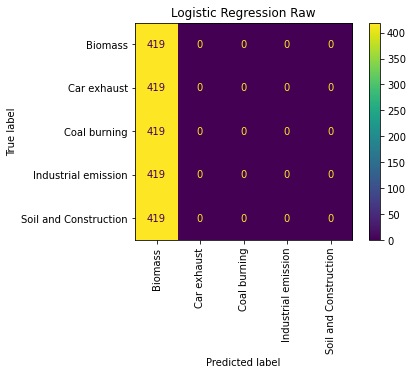

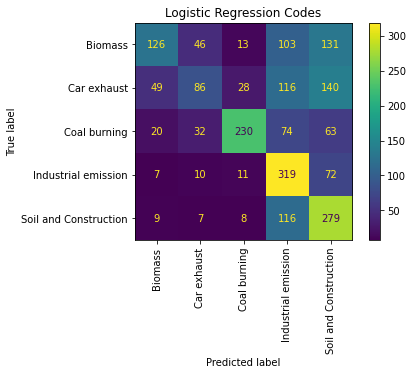

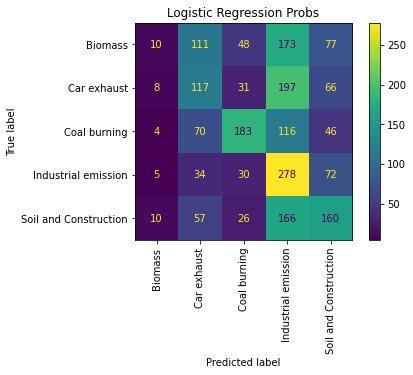

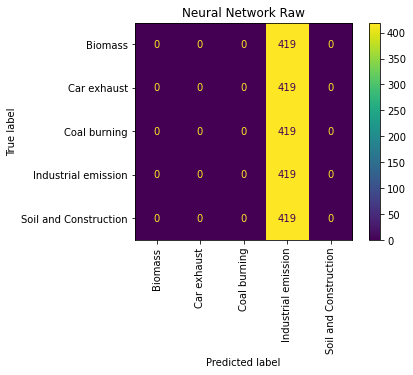

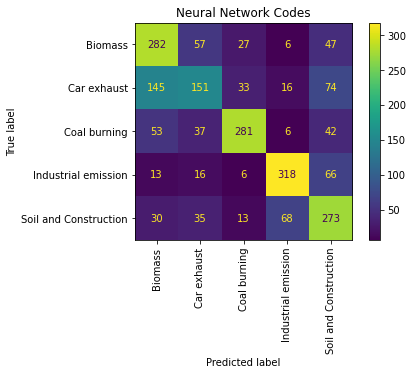

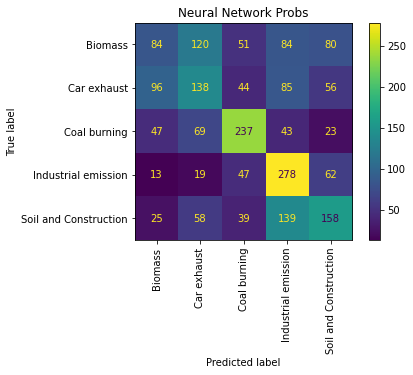

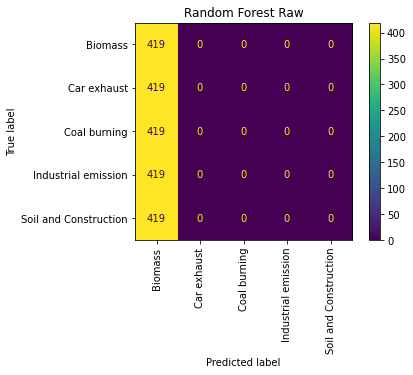

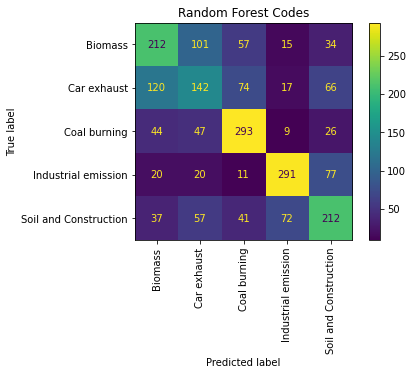

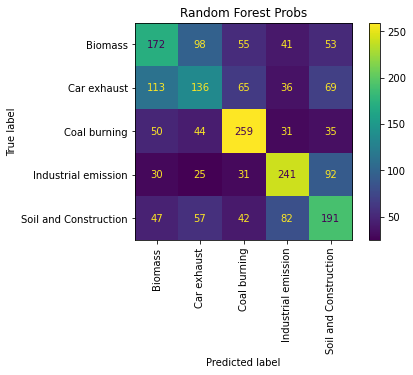

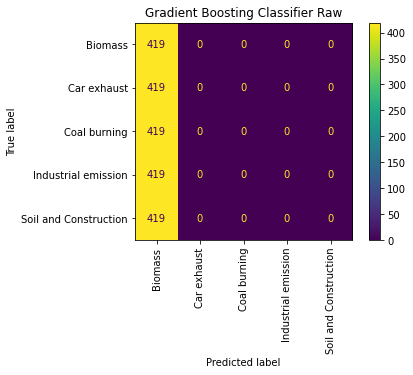

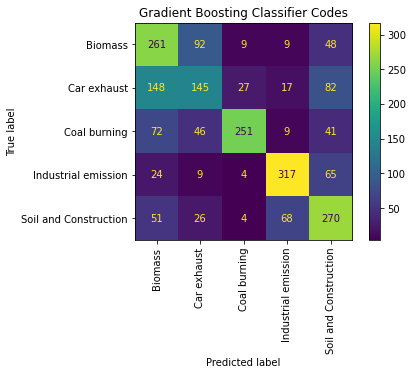

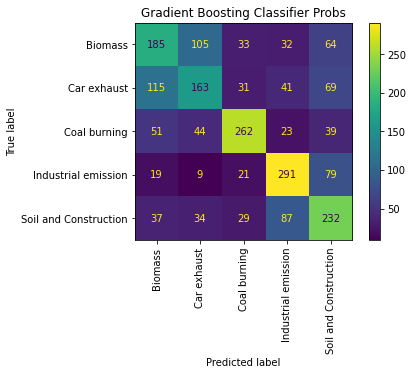

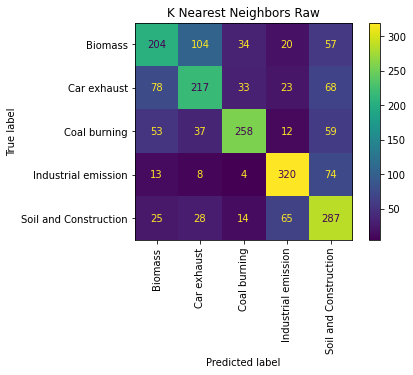

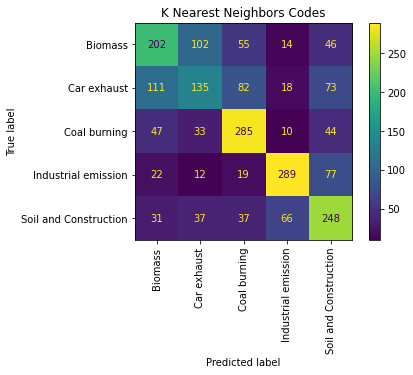

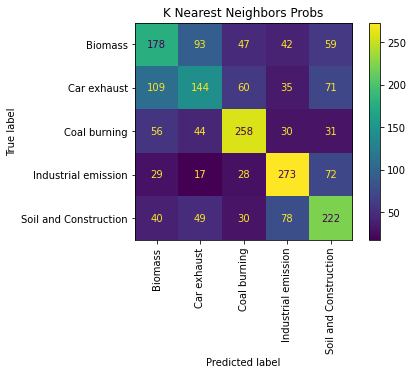

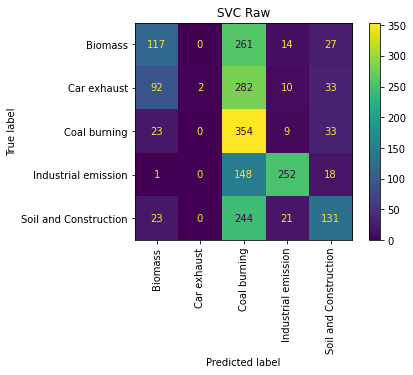

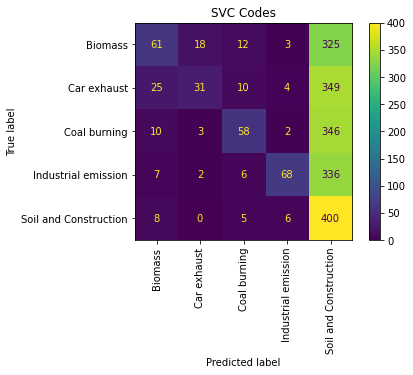

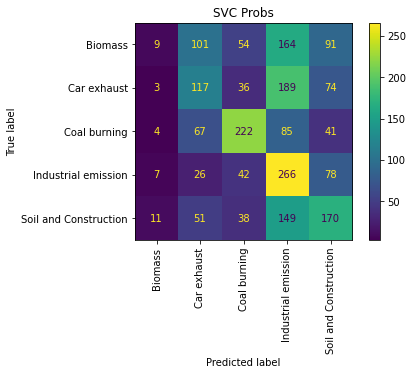

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

models = [LogisticRegression(), MLPClassifier(), RandomForestClassifier(), GradientBoostingClassifier(), KNeighborsClassifier(n_neighbors = 30, weights = 'distance'), SVC()]

Traindata = [Train, Train_codes, Train_prob]
Testdata = [Test, Test_codes, Test_prob]
modelkeys = ['Logistic Regression', 'Neural Network', 'Random Forest', 'Gradient Boosting Classifier', 'K Nearest Neighbors', 'SVC']
datatypelist = ['Raw', 'Codes', 'Probs']
columnsindex = ['Train', 'Test', 'Crossval mean', 'Crossval std']

dfraw = pd.DataFrame(index = modelkeys, columns = columnsindex)
dfcodes = pd.DataFrame(index = modelkeys, columns = columnsindex)
dfprobs = pd.DataFrame(index = modelkeys, columns = columnsindex)

dftotal = [dfraw, dfcodes, dfprobs]


for modelid, model in enumerate(models):
    for datatype in np.arange(0, len(Traindata)):
        clf = model.fit(Traindata[datatype], TrainLabels)
        #print([clf.score(Testdata[datatype], TestLabels), clf.score(Traindata[datatype], TrainLabels)])
        Testscore = clf.score(Testdata[datatype], TestLabels)
        Trainscore = clf.score(Traindata[datatype], TrainLabels)
        
        score = cross_val_score(model, Traindata[datatype], TrainLabels, cv = 5)
        #print([score.mean(), score.std()])
        dftotal[datatype].loc[modelkeys[modelid], 'Train'] = Trainscore
        dftotal[datatype].loc[modelkeys[modelid], 'Test'] = Testscore
        dftotal[datatype].loc[modelkeys[modelid], 'Crossval mean'] = score.mean()
        dftotal[datatype].loc[modelkeys[modelid], 'Crossval std'] = score.std()


        plot_confusion_matrix(clf, Testdata[datatype], TestLabels)
        plt.title(modelkeys[modelid] + ' ' + datatypelist[datatype])
        plt.xticks(rotation = 90)
        plt.savefig('Figures/confusionmatrix' + modelkeys[modelid] + datatypelist[datatype] + '.png', dpi = 300)
        

In [6]:
writer = ExcelWriter('outputdata/Results.xlsx', engine = 'xlsxwriter')
for i,j in enumerate(datatypelist):
    dftotal[i].to_excel(writer, sheet_name = j)
writer.save()

## ROC Curves

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle


C:\Users\Garret Bland\anaconda3\envs\TOF Classification\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Garret Bland\anaconda3\envs\TOF Classification\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

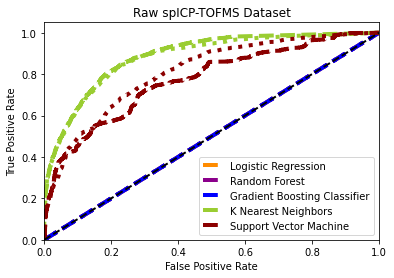

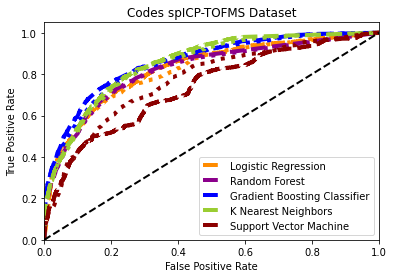

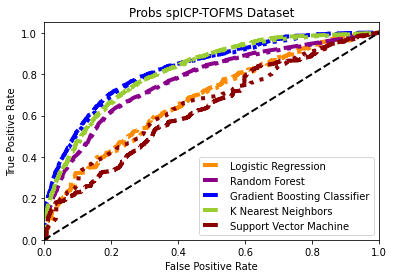

In [8]:
BinaryTrainlabels = label_binarize(TrainLabels, classes = Sourcekeys)
BinaryTestlabels = label_binarize(TestLabels, classes = Sourcekeys)
n_classes = BinaryTrainlabels.shape[1]
modelkeys = ['Logistic Regression', 'Random Forest', 'Gradient Boosting Classifier', 'K Nearest Neighbors', 'Support Vector Machine']
Traindata = [Train, Train_codes, Train_prob]
Testdata = [Test, Test_codes, Test_prob]
datakeys = ['Raw', 'Codes', 'Probs']

models = [LogisticRegression(), RandomForestClassifier(), GradientBoostingClassifier(), KNeighborsClassifier(n_neighbors = 30, weights = 'distance'), SVC(probability= True)]
colors = ['darkorange', 'darkmagenta', 'blue', 'yellowgreen', 'darkred']

datatypelist = []
for dataid, datatype in enumerate(Traindata):
    AUC_average = pd.DataFrame()
    plt.figure()
    for index, model in enumerate(models):
        # Learn to predict each class against the other
        classifier = OneVsRestClassifier(model)
        y_score = classifier.fit(datatype, BinaryTrainlabels).predict_proba(Testdata[dataid])

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(BinaryTestlabels[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(BinaryTestlabels.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        lw = 2
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        df =  pd.DataFrame(index = roc_auc.keys(), data = roc_auc.values())
        AUC_average = pd.concat([AUC_average, df], axis = 1)

        # Plot all ROC curves
        plt.plot(fpr["micro"], tpr["micro"],
                label= modelkeys[index],
                color= colors[index], linestyle='--', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                color= colors[index], linestyle=':', linewidth=4)

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')

    plt.ylabel('True Positive Rate')
    plt.title(datakeys[dataid] + ' spICP-TOFMS Dataset')
    plt.legend(loc="lower right")
    plt.savefig('Figures/ROCCurves' + datakeys[dataid] + '.png', dpi = 300)
    AUC_average.columns = modelkeys
    datatypelist.append(AUC_average)

In [9]:
writer = ExcelWriter('outputdata/ROCCurveresults.xlsx', engine = 'xlsxwriter')
for i,j in enumerate(datatypelist):
    j.to_excel(writer, sheet_name = datakeys[i])
writer.save()